# Homework 2
## Extracting TopUniversities and TimesHigherEducation Data

## Library

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import seaborn
%matplotlib inline

## Vars

In [2]:
web_urls = [{'page':'https://www.topuniversities.com',
             'data':'https://www.topuniversities.com/sites/default/files/qs-rankings-data/357051_indicators.txt'},
            {'page':'https://www.timeshighereducation.com/world-university-rankings/2018/world-ranking#!/page/0/length/25/sort_by/rank/sort_order/asc/cols/stats',
             'data':'https://www.timeshighereducation.com/sites/default/files/the_data_rankings/world_university_rankings_2018_limit0_369a9045a203e176392b9fb8f8c1cb2a.json'}]

#reading from pickle, avoid generating to many redundant traffic
tu_top200 = pd.read_pickle("tu_top200_pickle")
the_top200 = pd.read_pickle("the_top200_pickle")


## Functions

In [3]:
def get_number_elements(htmlPage, className):
    try:
        number = int(((htmlPage.find('div', class_=className)).find('div', class_="number").text).replace(',',''))    
    except AttributeError:
        number = 0
    return number

def crawl_topuniversities(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for idx,university in enumerate(universities):
        
        university_region = university['region']
        university_country = university['location']
        university_rank = university['overall_rank']
        
        university_info_html = BeautifulSoup(university['uni'], 'html.parser')
        link_element = university_info_html.find('a')
        
        university_name = link_element.text
        university_link = link_element.get('href')

        university_detail = requests.get(url['page']+university_link)
        university_detail_html = BeautifulSoup(university_detail.text, 'html.parser')
        
        n_f_members = get_number_elements(university_detail_html,"total faculty")    
        n_inter_f_members = get_number_elements(university_detail_html,"inter faculty") 
        
        n_students = get_number_elements(university_detail_html,"total student") 
        n_inter_students = get_number_elements(university_detail_html,"total inter") 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'region': university_region,
                                'total_faculty_members': n_f_members,
                                'total_international_faculty_members': n_inter_f_members,
                                'total_students': n_students,
                                'total_international_students': n_inter_students
                          })
        list_universities.append(university_data)
    
    universities = pd.DataFrame.from_dict(list_universities)
    
    return universities

def crawl_timeshighereducation(url,n_top):
    http_response = requests.get(url['data'])
    universities = http_response.json()['data'][:n_top]
    list_universities = []
    for university in universities:
        
        university_rank = university['rank']
        university_name = university['name']
        university_country = university['location']
        n_students = int(university['stats_number_students'].replace(',',''))
        student_staff_ratio = float(university['stats_student_staff_ratio'])
        inter_student_percentage = float(university['stats_pc_intl_students'].strip('%'))/100 
        
        university_data = ({
                                'rank': university_rank,
                                'university_name': university_name,
                                'country': university_country,
                                'student_staff_ratio': student_staff_ratio,
                                'percentage_international_students': inter_student_percentage,
                                'total_students': n_students
                          })
        list_universities.append(university_data)
        
    universities = pd.DataFrame.from_dict(list_universities)
    return universities   

## Main Homework

### 1.Analysis of Top Universities Data

In [12]:
tu_top200 = crawl_topuniversities(web_urls[0],200)

In [4]:
tu_top200.head()

,country,rank,region,total_faculty_members,total_international_faculty_members,total_international_students,total_students,university_name
0,United States,1,North America,2982,1679,3717,11067,Massachusetts Institute of Technology (MIT)
1,United States,2,North America,4285,2042,3611,15878,Stanford University
2,United States,3,North America,4350,1311,5266,22429,Harvard University
3,United States,4,North America,953,350,647,2255,California Institute of Technology (Caltech)
4,United Kingdom,5,Europe,5490,2278,6699,18770,University of Cambridge


#### 1a. Best Universities: Ratio Faculty Members / Students

In [5]:
f_members_students_r = pd.DataFrame(tu_top200.university_name)
f_members_students_r["faculty_member_student_ratio"] = (tu_top200.total_faculty_members/tu_top200.total_students)
f_members_students_r.sort_values("faculty_member_student_ratio",ascending=False).head(3)

,university_name,faculty_member_student_ratio
3,California Institute of Technology (Caltech),0.422616
15,Yale University,0.398323
5,University of Oxford,0.342292


#### 1b. Best Universities: International Student Ratio

In [6]:
inter_students_r = pd.DataFrame(tu_top200.university_name)
inter_students_r["international_student_ratio"] = (tu_top200.total_international_students/tu_top200.total_students)
inter_students_r.sort_values("international_student_ratio",ascending=False).head(3)

,university_name,international_student_ratio
34,London School of Economics and Political Scien...,0.691393
11,Ecole Polytechnique Fédérale de Lausanne (EPFL),0.570047
7,Imperial College London,0.543567


#### 1c. Best Universities: (1a) & (1b) by Country

In [8]:
df_c = f_members_students_r
df_c['country'] = tu_top200['country']
df_c['international_student_ratio'] = inter_students_r['international_student_ratio']

display(df_c.sort_values('faculty_member_student_ratio', ascending=False).groupby('country', as_index=False).first())
display(df_c.sort_values('international_student_ratio', ascending=False).groupby('country', as_index=False).first())

,country,university_name,faculty_member_student_ratio,region,international_student_ratio
0,Argentina,Universidad de Buenos Aires (UBA),0.134267,Latin America,0.221658
1,Australia,The Australian National University,0.110788,Oceania,0.384365
2,Austria,University of Vienna,0.074205,Europe,0.314748
3,Belgium,Vrije Universiteit Brussel (VUB),0.193020,Europe,0.199591
4,Brazil,Universidade de São Paulo,0.084948,Latin America,0.031745
5,Canada,McMaster University,0.136318,North America,0.149692
6,Chile,Pontificia Universidad Católica de Chile (UC),0.083694,Latin America,0.036700
7,China,Tsinghua University,0.151680,Asia,0.112176
8,Denmark,Technical University of Denmark,0.238455,Europe,0.236314
9,Finland,University of Helsinki,0.117980,Europe,0.055043


,country,university_name,faculty_member_student_ratio,region,international_student_ratio
0,Argentina,Universidad de Buenos Aires (UBA),0.134267,Latin America,0.221658
1,Australia,The University of Melbourne,0.078493,Oceania,0.427434
2,Austria,University of Vienna,0.074205,Europe,0.314748
3,Belgium,Vrije Universiteit Brussel (VUB),0.193020,Europe,0.199591
4,Brazil,Universidade Estadual de Campinas (Unicamp),0.074063,Latin America,0.036354
5,Canada,McGill University,0.126435,North America,0.330825
6,Chile,Pontificia Universidad Católica de Chile (UC),0.083694,Latin America,0.036700
7,China,Peking University,0.123054,Asia,0.168265
8,Denmark,Technical University of Denmark,0.238455,Europe,0.236314
9,Finland,Aalto University,0.103482,Europe,0.150737


#### 1d. Best Universities: (1a) & (1b) by Region

In [7]:
df_d = f_members_students_r
df_d['region'] = tu_top200['region']
df_d['international_student_ratio'] = inter_students_r['international_student_ratio']

display(df_d.sort_values('faculty_member_student_ratio', ascending=False).groupby('region', as_index=False).first())
display(df_d.sort_values('international_student_ratio', ascending=False).groupby('region', as_index=False).first())

,region,university_name,faculty_member_student_ratio,international_student_ratio
0,Africa,University of Cape Town,0.088450,0.169703
1,Asia,Pohang University of Science And Technology (P...,0.213025,0.040423
2,Europe,University of Oxford,0.342292,0.372870
3,Latin America,Instituto Tecnológico y de Estudios Superiores...,0.136214,0.105562
4,North America,California Institute of Technology (Caltech),0.422616,0.286918
5,Oceania,The Australian National University,0.110788,0.384365


,region,university_name,faculty_member_student_ratio,international_student_ratio
0,Africa,University of Cape Town,0.088450,0.169703
1,Asia,The University of Hong Kong,0.149006,0.407144
2,Europe,London School of Economics and Political Scien...,0.111475,0.691393
3,Latin America,Universidad de Buenos Aires (UBA),0.134267,0.221658
4,North America,Carnegie Mellon University,0.100479,0.478062
5,Oceania,The University of Melbourne,0.078493,0.427434


#### Plot

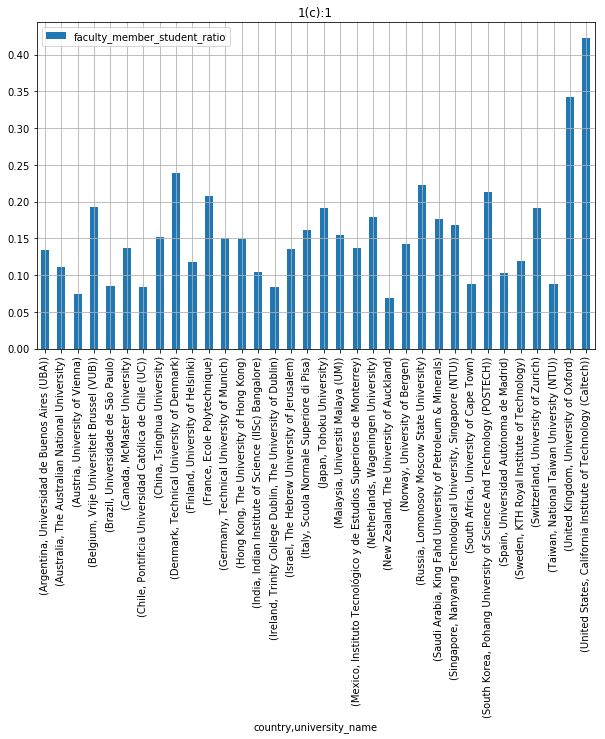

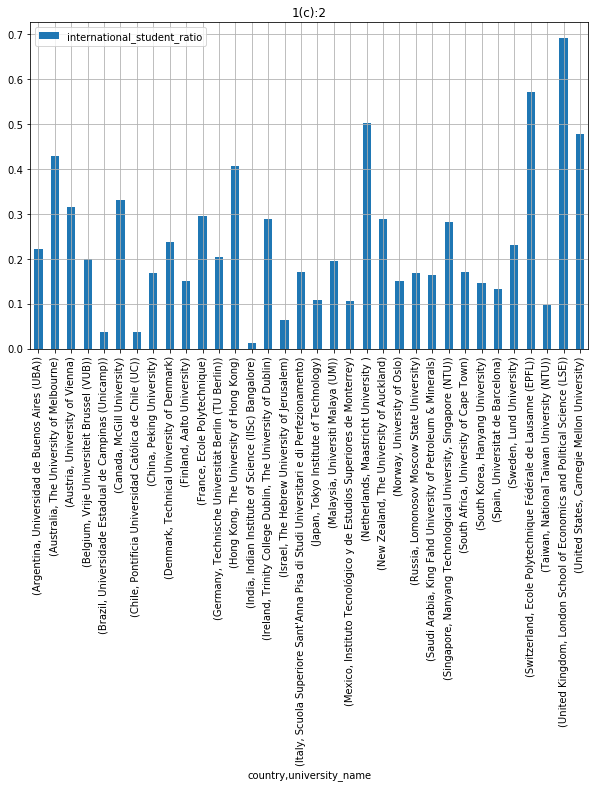

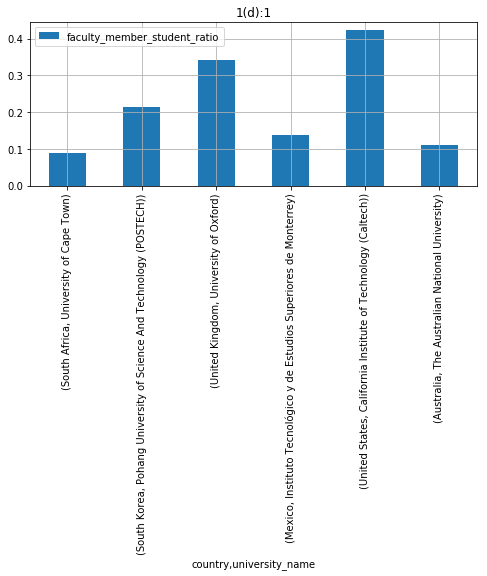

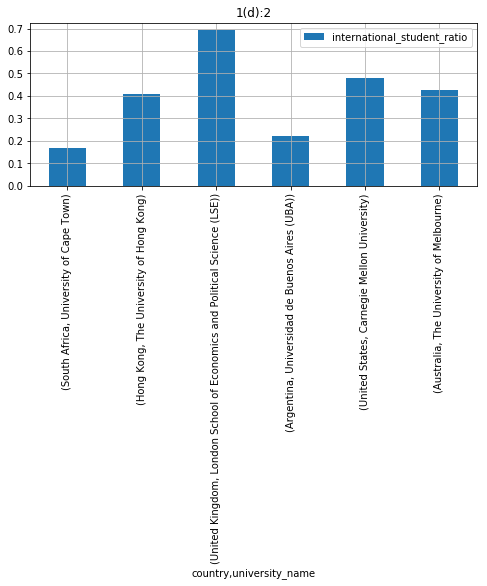

In [107]:
plot01_data = df_c.sort_values('faculty_member_student_ratio', ascending=False).groupby('country', as_index=False).first()
plot02_data = df_c.sort_values('international_student_ratio', ascending=False).groupby('country', as_index=False).first()

plot03_data = df_d.sort_values('faculty_member_student_ratio', ascending=False).groupby('region', as_index=False).first()
plot04_data = df_d.sort_values('international_student_ratio', ascending=False).groupby('region', as_index=False).first()

plot01=plot01_data.plot(y='faculty_member_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='1(c):1')
plot02=plot02_data.plot(y='international_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='1(c):2')
plot03=plot03_data.plot(y='faculty_member_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(8, 3), title='1(d):1')
plot04=plot04_data.plot(y='international_student_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(8, 3), title='1(d):2')


* Writing Data into a file

In [15]:
tu_top200.to_pickle("tu_top200_pickle")

### 2.Analysis of Times Higher Education Data

In [8]:
the_top200 = crawl_timeshighereducation(web_urls[1],200)

In [123]:
the_top200.head()

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,United Kingdom,0.38,1,11.2,20409,University of Oxford
1,United Kingdom,0.35,2,10.9,18389,University of Cambridge
2,United States,0.27,=3,6.5,2209,California Institute of Technology
3,United States,0.22,=3,7.5,15845,Stanford University
4,United States,0.34,5,8.7,11177,Massachusetts Institute of Technology


#### 2a. Best Universities: Student/Staff Ratio

In [9]:
the_top200.sort_values("student_staff_ratio",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
99,Germany,0.13,=100,77.9,35619,University of Bonn
124,Germany,0.16,125,74.5,10995,University of Mannheim
91,Germany,0.20,92,64.3,22390,Technical University of Berlin


#### 2b. Best Universities: International Student Ratio

In [10]:
the_top200.sort_values("percentage_international_students",ascending=False).head(3)

,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
24,United Kingdom,0.71,=25,12.2,10065,London School of Economics and Political Science
178,Luxembourg,0.57,=179,14.6,4969,University of Luxembourg
37,Switzerland,0.55,=38,11.2,9928,École Polytechnique Fédérale de Lausanne


#### 2c. Best Universities: (2a) & (2b) by Country

In [11]:
display(the_top200.sort_values('student_staff_ratio', ascending=False).groupby('country', as_index=False).first())
display(the_top200.sort_values('percentage_international_students', ascending=False).groupby('country', as_index=False).first())


,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,Australia,0.26,65,35.7,38968,University of Queensland
1,Austria,0.26,=165,20.8,35375,University of Vienna
2,Belgium,0.35,=175,43.4,25343,Université Libre de Bruxelles
3,Canada,0.15,78,24.7,23693,McMaster University
4,China,0.10,=169,14.2,33456,Nanjing University
5,Denmark,0.12,=109,14.3,25167,Aarhus University
6,Finland,0.20,190,20.2,12744,Aalto University
7,France,0.15,196,30.2,22042,Paris-Sorbonne University – Paris 4
8,Germany,0.13,=100,77.9,35619,University of Bonn
9,Hong Kong,0.25,=182,26.9,21773,Hong Kong Polytechnic University


,country,percentage_international_students,rank,student_staff_ratio,total_students,university_name
0,Australia,0.40,32,26.6,42116,University of Melbourne
1,Austria,0.26,=165,20.8,35375,University of Vienna
2,Belgium,0.35,=175,43.4,25343,Université Libre de Bruxelles
3,Canada,0.29,=34,18.1,51889,University of British Columbia
4,China,0.16,=27,8.9,42136,Peking University
5,Denmark,0.24,=153,6.0,8548,Technical University of Denmark
6,Finland,0.20,190,20.2,12744,Aalto University
7,France,0.36,115,5.1,2799,École Polytechnique
8,Germany,0.23,41,54.4,38689,Technical University of Munich
9,Hong Kong,0.42,40,18.0,18364,University of Hong Kong


#### Plot

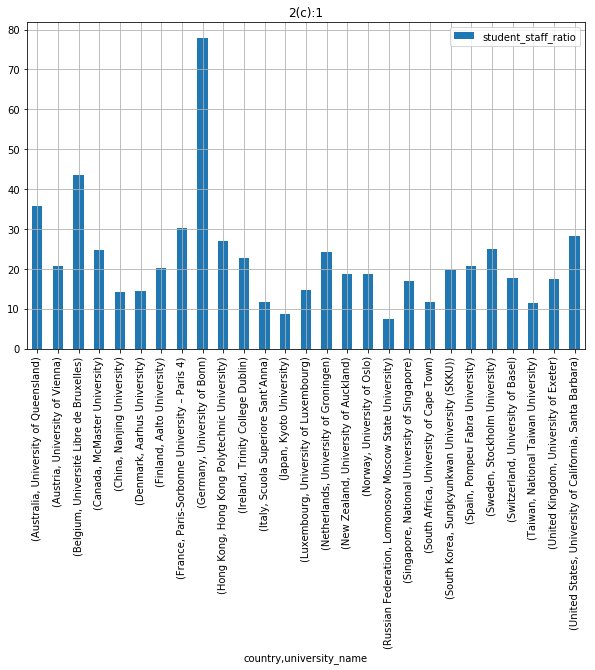

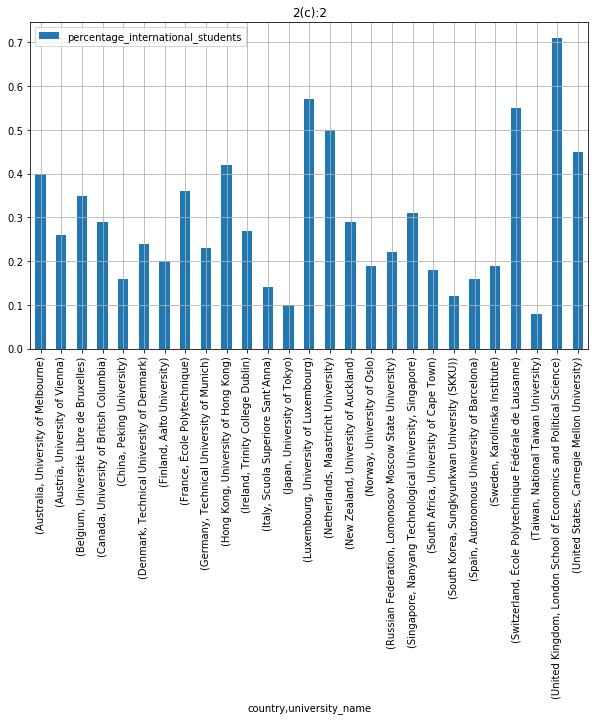

In [3]:
plot11_data = the_top200.sort_values('student_staff_ratio', ascending=False).groupby('country', as_index=False).first()
plot12_data = the_top200.sort_values('percentage_international_students', ascending=False).groupby('country', as_index=False).first()

plot11=plot11_data.plot(y='student_staff_ratio', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='2(c):1')
plot12=plot12_data.plot(y='percentage_international_students', x=['country','university_name'], kind='bar', grid=True, figsize=(10, 6), title='2(c):2')


* Writing Data into a file

In [16]:
the_top200.to_pickle("the_top200_pickle")

### 3.Merging Dataframe

In [12]:
#x = pd.merge(tu_top200,the_top200,left_index=True, right_on='university_name')
#x.head(5)

df1 = tu_top200
df1 = (df1.set_index(['university_name'])).add_prefix("tu_")

df2 = the_top200
df2 = (df2.set_index(['university_name'])).add_prefix("the_")

x = pd.concat([df1, df2], axis=1)
x.loc[(x['tu_country'] == "Switzerland")]

,tu_country,tu_rank,tu_region,tu_total_faculty_members,tu_total_international_faculty_members,tu_total_international_students,tu_total_students,the_country,the_percentage_international_students,the_rank,the_student_staff_ratio,the_total_students
ETH Zurich - Swiss Federal Institute of Technology,Switzerland,10,Europe,2477.0,1886.0,7563.0,19815.0,NaN,NaN,NaN,NaN,NaN
Ecole Polytechnique Fédérale de Lausanne (EPFL),Switzerland,12,Europe,1695.0,1300.0,5896.0,10343.0,NaN,NaN,NaN,NaN,NaN
University of Basel,Switzerland,149,Europe,1057.0,684.0,3441.0,12852.0,Switzerland,0.27,=95,17.7,12729.0
University of Bern,Switzerland,167,Europe,1172.0,661.0,1618.0,10758.0,Switzerland,0.15,=105,16.5,10449.0
University of Geneva,Switzerland,98,Europe,1752.0,1029.0,6104.0,15844.0,Switzerland,0.40,=130,15.1,16085.0
University of Lausanne,Switzerland,146,Europe,2173.0,1031.0,3337.0,13435.0,Switzerland,0.25,152,13.6,13065.0
University of Zurich,Switzerland,73,Europe,4997.0,2617.0,5036.0,26065.0,Switzerland,0.20,136,5.9,26363.0


In [13]:
x.loc[(x['the_country'] == "Switzerland")]

,tu_country,tu_rank,tu_region,tu_total_faculty_members,tu_total_international_faculty_members,tu_total_international_students,tu_total_students,the_country,the_percentage_international_students,the_rank,the_student_staff_ratio,the_total_students
ETH Zurich – Swiss Federal Institute of Technology Zurich,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,0.38,=10,14.6,19233.0
University of Basel,Switzerland,149,Europe,1057.0,684.0,3441.0,12852.0,Switzerland,0.27,=95,17.7,12729.0
University of Bern,Switzerland,167,Europe,1172.0,661.0,1618.0,10758.0,Switzerland,0.15,=105,16.5,10449.0
University of Geneva,Switzerland,98,Europe,1752.0,1029.0,6104.0,15844.0,Switzerland,0.40,=130,15.1,16085.0
University of Lausanne,Switzerland,146,Europe,2173.0,1031.0,3337.0,13435.0,Switzerland,0.25,152,13.6,13065.0
University of Zurich,Switzerland,73,Europe,4997.0,2617.0,5036.0,26065.0,Switzerland,0.20,136,5.9,26363.0
École Polytechnique Fédérale de Lausanne,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Switzerland,0.55,=38,11.2,9928.0


In [47]:
x[:31]

,tu_country,tu_rank,tu_region,tu_total_faculty_members,tu_total_international_faculty_members,tu_total_international_students,tu_total_students,the_country,the_percentage_international_students,the_rank,the_student_staff_ratio,the_total_students
Aalto University,Finland,137,Europe,1257.0,370.0,1831.0,12147.0,Finland,0.20,190,20.2,12744.0
Aarhus University,Denmark,119,Europe,2316.0,602.0,3762.0,26226.0,Denmark,0.12,=109,14.3,25167.0
Albert-Ludwigs-Universitaet Freiburg,Germany,171,Europe,1966.0,413.0,3897.0,23214.0,NaN,NaN,NaN,NaN,NaN
Alma Mater Studiorum - University of Bologna,Italy,188,Europe,2990.0,153.0,4195.0,63399.0,NaN,NaN,NaN,NaN,NaN
Arizona State University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,0.19,=126,20.1,44475.0
Australian National University,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Australia,0.35,48,19.3,15986.0
Autonomous University of Barcelona,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Spain,0.16,=147,12.9,32309.0
Boston University,United States,81,North America,3157.0,379.0,7041.0,25662.0,United States,0.25,=70,8.6,24833.0
Brown University,United States,53,North America,1303.0,379.0,1825.0,9251.0,United States,0.20,=50,10.7,8898.0
California Institute of Technology,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,0.27,=3,6.5,2209.0


In [57]:
l = []
for index, row in df1[:15].iterrows():
    keyword = index.split()[0] + " " + index.split()[1]
    if(keyword == "University of"):
        keyword = index.split()[2]
    c = df2.filter(like=keyword, axis=0)
    l.append(c)
res = pd.concat(l)
res[:15]

# Found the way to handle non-ascii characters
#unicodedata.normalize("NFKD",u).encode('ascii','ignore')
#m = c.decode("utf-8", "strict")

# The matching indexes
# comparing index
# idx = (df1.index).isin(df2.index)
# idx.shape

,the_country,the_percentage_international_students,the_rank,the_student_staff_ratio,the_total_students
university_name,,,,,
Massachusetts Institute of Technology,United States,0.34,5,8.7,11177
Stanford University,United States,0.22,=3,7.5,15845
Harvard University,United States,0.26,6,8.9,20326
California Institute of Technology,United States,0.27,=3,6.5,2209
University of Cambridge,United Kingdom,0.35,2,10.9,18389
University of Oxford,United Kingdom,0.38,1,11.2,20409
Imperial College London,United Kingdom,0.55,8,11.4,15857
University of Chicago,United States,0.25,9,6.2,13525
ETH Zurich – Swiss Federal Institute of Technology Zurich,Switzerland,0.38,=10,14.6,19233


In [56]:
df2.filter(like='ETH Zurich',axis=0)

,the_country,the_percentage_international_students,the_rank,the_student_staff_ratio,the_total_students
university_name,,,,,
ETH Zurich – Swiss Federal Institute of Technology Zurich,Switzerland,0.38,=10,14.6,19233
